# Assignment 4 (Deadline 5. December 23:59)

- Espen Larsen
    - Student number: 216087
- Amund R. Brevik
    - Student number: 258907

### Imports and reload block

In [1]:
import PythonFunctions
import importlib
importlib.reload(PythonFunctions)
from pathlib import Path
from PythonFunctions import make_mw_sector
from PythonFunctions import CLUSTER_OUTLINE_COLORS
from PythonFunctions import set_global_seed, plot_country, plot_with_linear_fit, train_nn_ebola, plot_nn_result, train_lstm_ebola, plot_lstm_result, run_country_poly_basic
DATA_DIR = Path("data") 
COUNTRIES = {
    "Guinea":       DATA_DIR / "ebola_cases_guinea.dat",
    "Liberia":      DATA_DIR / "ebola_cases_liberia.dat",
    "Sierra Leone": DATA_DIR / "ebola_cases_sierra_leone.dat",
    }


# Topic 1: Unsupervised learning: Clustering the Milky Way

In Topic 1, the goal was to explore how unsupervised learning methods can be applied to astronomical images and what kinds of structures they are able to detect. Using the mw_plot library, we generated different sky sectors of the Milky Way and converted the resulting images into numerical feature representations such as greyscale brightness, HSV color components, and RGB values. These encodings were then clustered using the K-means algorithm to identify patterns based purely on pixel level information, without any labels or prior assumptions.

The aim was not to perform precise astrophysical analysis, but to understand how the choice of encoding affects the clusters produced, and to reflect on the strengths and limitations of unsupervised learning in a scientific context. This provided a practical demonstration of how machine learning models interpret image data, and how the results depend strongly on the representations we choose.

### Task 0 & 1

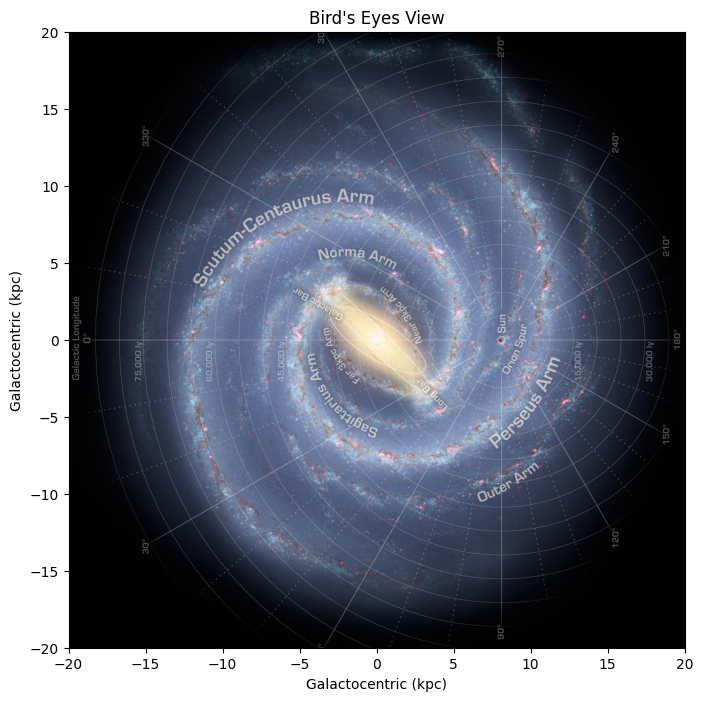

In [9]:
import numpy as np
from astropy import units as u
from mw_plot import MWFaceOn

mw1 = MWFaceOn(
    radius=20 * u.kpc,
    unit=u.kpc,
    coord="galactocentric",
    annotation=True,
    figsize=(10, 8),
)

mw1.title = "Bird's Eyes View"

mw1.scatter(8 * u.kpc, 0 * u.kpc, c="r", s=2)

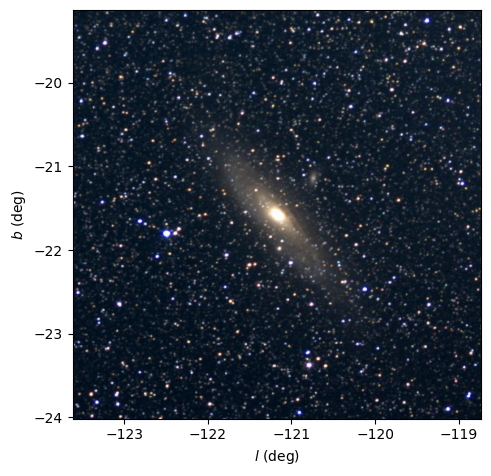

In [10]:
import matplotlib.pyplot as plt

from astropy import units as u

from mw_plot import MWSkyMap

mw1 = MWSkyMap(
    center="M31",
    radius=(8800, 8800) * u.arcsec,
    background="Mellinger color optical survey",
)

fig, ax = plt.subplots(figsize=(5, 5))

mw1.transform(ax)

mw1.savefig('galaxy.png')

### Task 2

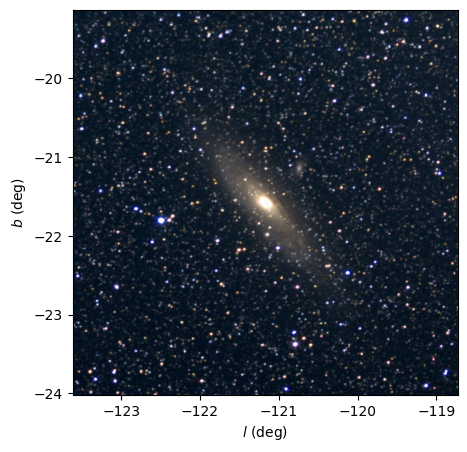

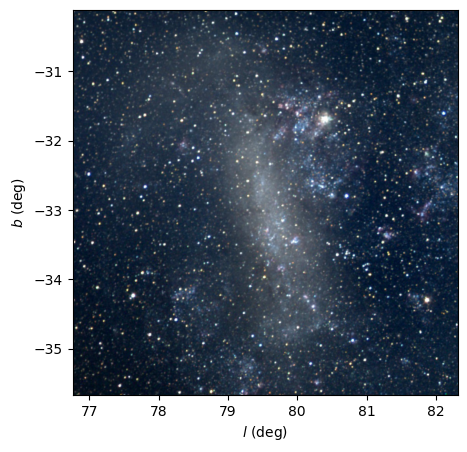

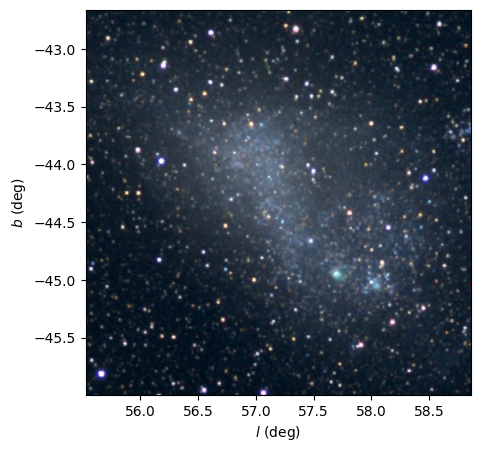

In [11]:
from PythonFunctions import make_mw_sector

# 1. M31, radius 8800"
fig1, ax1 = make_mw_sector(
    center="M31",
    radius_x_arcsec=8800,
    background="Mellinger color optical survey",
    projection="equirectangular",
    figsize=(5, 5),
    savepath="m31_8800.png",
    show=True,
)

# 2. LMC, different center and radius 10000"
fig2, ax2 = make_mw_sector(
    center="LMC",
    radius_x_arcsec=10000,
    background="Mellinger color optical survey",
    projection="equirectangular",
    figsize=(5, 5),
    savepath="lmc_10000.png",
    show=True,
)

# 3. SMC, different center and radius 6000"
fig3, ax3 = make_mw_sector(
    center="SMC",
    radius_x_arcsec=6000,
    background="Mellinger color optical survey",
    projection="equirectangular",
    figsize=(5, 5),
    savepath="smc_6000.png",
    show=True,
)




### Task 3

In [12]:
from PythonFunctions import plt2rgbarr

img_array = plt2rgbarr(fig)
print(img_array.shape)  


(500, 500, 3)


### Task 4

From task 3 we have gotten an image converted into a red, blue , green(RGB) array, where each pixel is a list of 3 numbers representing R, G and B intensities. Next up is to choose an encoding strategy which can later be used for clustering categories. As the teacher example hinted as, we decided to start with greyscale encoding, where each pixel encodes into greyscale, giving us a single number that shows the brightness intensity of each pixel. 

Brightness intensity is a natural starting point when clustering astronomical images. As different pixel brightness' can be used to cluster into different categories such as:
- Low brightness pixels -> outer rim, dark features of the image
- Medium brightness pixels -> bright stars and dense regions
- Very bright pixels -> The core of the galaxy and the brightest stars


### Task 5

In [13]:
from PythonFunctions import run_kmeans_on_greyscale

# Running K-means clustering on greyscale pixels
labels, coords, features, grey, kmeans_model = run_kmeans_on_greyscale(
    img_array,
    grey_threshold = 230.0,
    n_clusters = 3,
    random_state = 0,
)

print("Number of bright pixels:", features.shape[0])
print("Feature shape:", features.shape)
print("Cluster centers (brightness):", kmeans_model.cluster_centers_.ravel())

Number of bright pixels: 540
Feature shape: (540, 1)
Cluster centers (brightness): [250.37147345 234.11527389 242.43215924]


### Task 5 summary
We select a greyscale threshold value of 230 (on a 0–255 brightness scale) to isolate the brightest pixels in the image. 
Choosing a high threshold to extract bright sources such as stars and galaxy cores is standard practice in both 
general image processing [2,4] and astronomical source detection workflows [3].


### Task 6

We cluster bright pixels using greyscale brightness and overimpose the clusters on the original image.

Greyscale clusters:
Cluster 0: brightness ≈ 250.4, outline color = red
Cluster 1: brightness ≈ 234.1, outline color = lime
Cluster 2: brightness ≈ 242.4, outline color = cyan


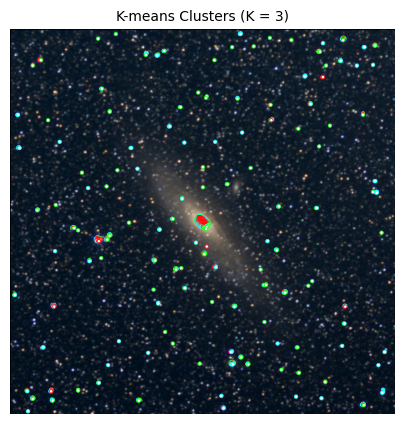

In [14]:
from PythonFunctions import overimpose_clusters_on_image

fig_clusters, ax_clusters = overimpose_clusters_on_image(
    img_array=img_array,
    coords=coords,
    labels=labels,
    n_clusters=3,
    figsize=(5, 5),
    point_size=6.0,
    alpha=0.9,
)

# Printing clusters, mapping brightness value to color in overimposed image
centers = kmeans_model.cluster_centers_.ravel()

print("Greyscale clusters:")
for cluster_id, brightness in enumerate(centers):
    color = CLUSTER_OUTLINE_COLORS[cluster_id % len(CLUSTER_OUTLINE_COLORS)]
    print(
        f"Cluster {cluster_id}: "
        f"brightness ≈ {brightness:.1f}, "
        f"outline color = {color}"
    )

### Task 6 - Summary on Greyscale encoding

“Note: The outline colors (red, lime, cyan) are not the actual colors present in the image.
They are simply visual markers identifying the cluster groups, kept consistent across greyscale, HSV, and RGB encodings.”

Each cluster is visualized with a fixed color for the greyscale clusters:
- **Cluster 1: brightness ≈ 234.1 → outline color = LIME**
    - This represents the dimmest regions above our greyscale threshold, typically corresponding to faint outskirts, low-density stellar regions, or background structure.
- **Cluster 2: brightness ≈ 242.4 → outline color = CYAN**
    - Corresponds to intermediate brightness, often associated with bright stars and moderately dense stellar fields.
- **Cluster 0: brightness ≈ 250.4 → outline color = RED**
    - Represents the brightest regions in the image like the galaxy core and a couple of other very bright regions.

Greyscale encoding limitations:
- Loses all color information
    - Different stellar populations with different colors can collapse into the same cluster. [1], [6], [7]
- Brightness mixes physical and non-physical effects
    - Dust, aging stars, camera response, and rendering choices all influence brightness. [1], [5]

It is important to highlight that although we map the clusters to **faint outskirts -> bright stars -> Galaxy core**, it is hard to know exactly what those regions actually contain(as discussed by Kelvin et al., 2023[5]) and are for our demonstration purposes simplified into these categories.

### Task 7 - HSV color encoding

There are also other natural encodings to use in astronomical images clustering, two of which we will implement in task 7(these are discussed by Rector (2007) [1]):

HSV Encoding(Hue, Saturation, Value):
With HSV we can convert the image into Hue, Saturation and Value, and represent pixels into a more natural form for humans to understand.
- Hue -> The dominant color
- Saturation -> How "pure" the color is
- Value -> pixel brightness

RGB color encoding:
Instead of converting into a single brightness number, we can keep the RGB values and cluster into categories using color temperature.
- Blueish regions -> young, hot stars
- Yellowish regions -> Older stars
- Reddish regions -> Dust or gas clouds

HSV clusters (Hue, Saturation):
Cluster 0: H ≈ 0.14, S ≈ 0.07, outline color = red
Cluster 1: H ≈ 0.79, S ≈ 0.03, outline color = lime
Cluster 2: H ≈ 0.51, S ≈ 0.04, outline color = cyan


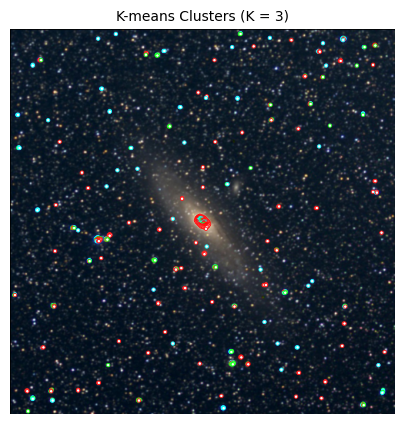

In [15]:
from PythonFunctions import run_kmeans_on_hsv

# Run K-means on HSV (Hue, Saturation) encoding
labels_hsv, coords_hsv, features_hsv, hsv_image, kmeans_hsv = run_kmeans_on_hsv(
    img_array,
    grey_threshold=230.0,
    n_clusters=3,
    random_state=0,
)

centers_hsv = kmeans_hsv.cluster_centers_ 

print("HSV clusters (Hue, Saturation):")
for cluster_id, (h, s) in enumerate(centers_hsv):
    color = CLUSTER_OUTLINE_COLORS[cluster_id % len(CLUSTER_OUTLINE_COLORS)]
    print(
        f"Cluster {cluster_id}: "
        f"H ≈ {h:.2f}, S ≈ {s:.2f}, "
        f"outline color = {color}"
    )

# Overlay these clusters on the original image
fig_hsv_clusters, ax_hsv_clusters = overimpose_clusters_on_image(
    img_array=img_array,
    coords=coords_hsv,
    labels=labels_hsv,
    n_clusters=3,
    figsize=(5, 5),
    point_size=6.0,
    alpha=0.9,
)

### Task 7: HSV encoding summary

For the HSV encoding, each pixel is represented by its Hue (H) and Saturation (S).
K-means (K = 3) produced the following cluster centers:

- **Cluster 0: H ≈ 0.14, S ≈ 0.07 → outline color = RED**  
  - These pixels are characterized by a warm hue and low saturation, often appearing
    as yellowish or washed-out regions in the original RGB image.

- **Cluster 1: H ≈ 0.79, S ≈ 0.03 → outline color = LIME**  
  - Represents faint, low-saturation areas, typically associated with diffuse or
    background regions where little color information is present.

- **Cluster 2: H ≈ 0.51, S ≈ 0.04 → outline color = CYAN**  
  - Corresponds to cooler-toned, slightly bluer regions such as certain star-forming
    or diffuse structures.

HSV Encoding Limitations: 
- Hue unstable for low-saturation pixels
  - Many bright pixels are nearly white → Hue becomes ambiguous. [8]
- HSV is derived from RGB rendering
  - Not from real astrophysical filters. [1], [8]
- Does not correspond directly to physical color temperature
  - True stellar colors must be measured in calibrated bands (e.g., g, r, i filters). [6], [7]

**Note:**  
The outline colors (red, lime, cyan) are **not related to the actual color of the
astronomical region**. They are simply **consistent cluster-label colors** used across
all encoding methods (greyscale, HSV, RGB) to make comparison easier.


### Task 7: RGB color encoding


RGB clusters (mean normalized color):
Cluster 0: R ≈ 0.92, G ≈ 0.93, B ≈ 0.95, outline color = red
Cluster 1: R ≈ 0.97, G ≈ 0.94, B ≈ 0.85, outline color = lime
Cluster 2: R ≈ 0.98, G ≈ 0.98, B ≈ 0.97, outline color = cyan


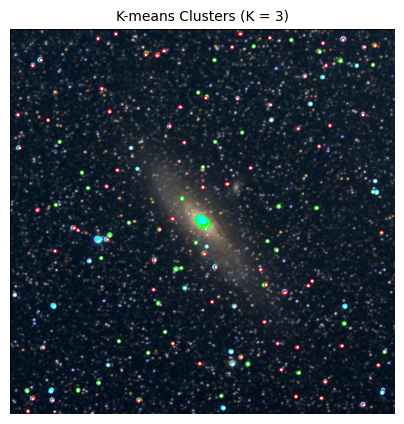

In [16]:
from PythonFunctions import run_kmeans_on_rgb

# Run K-Means on RGB encoding
labels_rgb, coords_rgb, features_rgb, kmeans_rgb = run_kmeans_on_rgb(
    img_array,
    grey_threshold=230.0,
    n_clusters=3,
    random_state=0,
)

# Overlay RGB clusters on the image
fig_rgb_clusters, ax_rgb_clusters = overimpose_clusters_on_image(
    img_array=img_array,
    coords=coords_rgb,
    labels=labels_rgb,
    n_clusters=3,
    figsize=(5, 5),
    point_size=6.0,
    alpha=0.9,
)

centers_rgb = kmeans_rgb.cluster_centers_

print("RGB clusters (mean normalized color):")
for cid, center in enumerate(centers_rgb):
    r, g, b = center
    color = CLUSTER_OUTLINE_COLORS[cid % len(CLUSTER_OUTLINE_COLORS)]
    print(
        f"Cluster {cid}: "
        f"R ≈ {r:.2f}, G ≈ {g:.2f}, B ≈ {b:.2f}, "
        f"outline color = {color}"
    )

### Task 7: RGB color encoding summary

For the RGB encoding, each pixel is represented by its normalized Red, Green, and Blue values.
K-means (K = 3) produced the following cluster centers:

- **Cluster 0: (R,G,B) ≈ (0.92, 0.93, 0.95) → outline color = RED**
    - These RGB values are nearly equal, producing a light grey–white tone.
    - Corresponds to neutral-colored regions, often the washed-out central disk or bright stellar fields where the image is close to saturation.

- **Cluster 1: (R,G,B) ≈ (0.97, 0.94, 0.85) → outline color = LIME**
    - Slightly more red/yellow relative to blue.
    - Likely identifies warmer-toned areas, such as older stellar populations or dust-rich regions, where the galaxy light is subtly reddened.

- **Cluster 2: (R,G,B) ≈ (0.98, 0.98, 0.97) → outline color = CYAN**
    - Very bright, nearly pure white with slight cool bias.
    - Often corresponds to the brightest compact stars and highly luminous core regions, where all color channels are strongly saturated.

RGB Encoding Limitations:
- RGB channels are highly correlated in bright regions
    - Most bright pixels are nearly white → clustering becomes sensitive to tiny variations. [8], [10]
- Brightness and color are entangled
    - The model cannot distinguish “bright because white” from “bright because blue/red”. [1], [9], [10]
- Still based on rendered colors
    - Not true photometric measurements. [1], [10]

### Task 7 discussion and summary

In Task 7 we repeated the K-means clustering (K = 3) using three different encodings of the same M31 sector:
- Greyscale brightness (1D: intensity)
- HSV color (2D: Hue, Saturation)
- RGB color (3D: R, G, B)

All three methods use the same brightness threshold (grey > 230) to focus on bright pixels, and we over-impose the resulting clusters on top of the Task 2 image with fixed outline colors:
- Cluster 0 → red outline
- Cluster 1 → lime outline
- Cluster 2 → cyan outline

The outline colors are purely visual labels and do not represent the physical color of the galaxy regions.

### What Do We Learn from These Unsupervised Models?

Across all three encodings, without any labels and using only image pixels, K-means discovers:
- A bright, compact component (galactic core + brightest stars)
- An intermediate component (spiral arms, bright stellar fields)
- A fainter component (outer / diffuse structures and outskirts)

Greyscale encoding recovers the overall brightness structure.
HSV and RGB encodings add information about color tone and balance, pointing towards potentially different stellar populations or dust effects.

This shows that unsupervised learning can:
- Reveal coherent structures (clusters) in the data
- Help us segment the galaxy image into components that resemble bulge, disk, and outskirts
- Provide a way to compare different feature encodings and see what information they emphasize

But it’s also important to recognize that the clustering algorithm “knows nothing” about astrophysics; it only groups pixels that look similar in the chosen feature space.

 ### Limitations of Our Approach

- Not photometrically calibrated
    - The images we use are 8-bit RGB renderings, not calibrated flux or surface-brightness measurements. Pixel values (0–255) depend on the visualization pipeline, not directly on physical luminosity.

- Threshold choice is arbitrary
    - We only cluster pixels with grey > 230.

- K-means assumptions
    - K-means assumes:
        - clusters are roughly spherical in feature space,
        - clusters are separated primarily by Euclidean distance,
        - K (number of clusters) is fixed by us.
    - Real galaxy structure is much more complex and does not necessarily fit spherical clusters in brightness or color space.

- Image-level, not physics-level
    - Clusters are discovered in the image space, which can be influenced by:
        - noise
        - background subtraction,
        - PSF and scattered light,
        - sky subtraction errors.
    - As discussed in Kelvin et al. (2023) [5], even professional low-surface-brightness studies struggle with these issues, so our interpretations must remain qualitative.

### Conclusion

Unsupervised clustering on different encodings (greyscale, HSV, RGB) gives us three complementary “views” of the same galaxy image:
- Greyscale emphasizes structure in brightness (core vs arms vs outskirts).
- HSV emphasizes structure in color space (warm vs cool, desaturated vs slightly saturated).
- RGB refines the very bright regions by small differences in color balance.

Together, they demonstrate how an unsupervised model can discover meaningful patterns in astronomical images, but also how strongly the results depend on the chosen encoding and on the limitations of the underlying image data.

# Topic 2: Supervised learning: Machines versus human models, who can save the world??

### Task 0 : Reproduce the project 2 exercise 5 plots for Ebola epidemic in West Africa



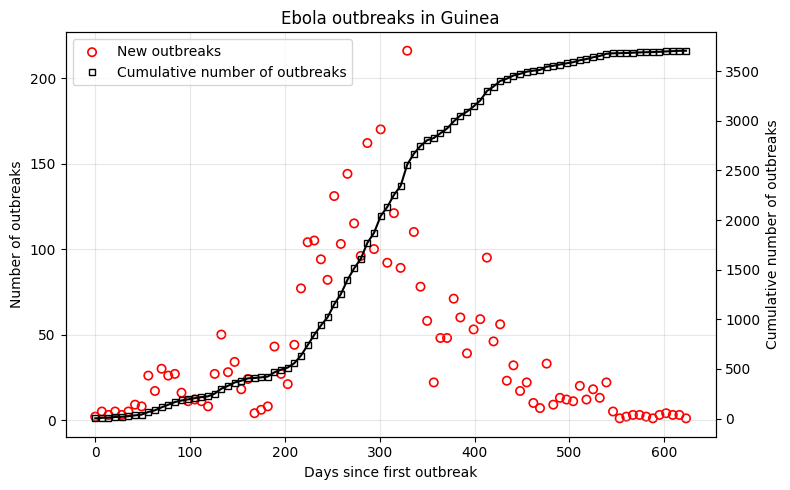

Guinea: total cumulative = 3707, peak new = 216 at day ≈ 329


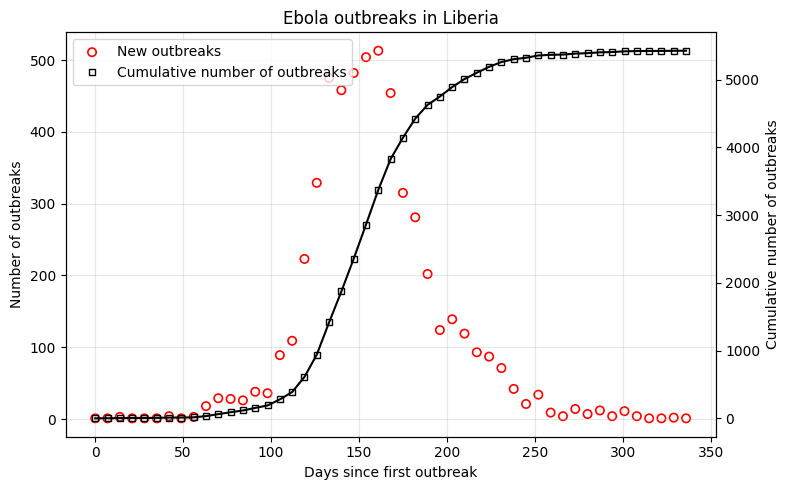

Liberia: total cumulative = 5425, peak new = 513 at day ≈ 161


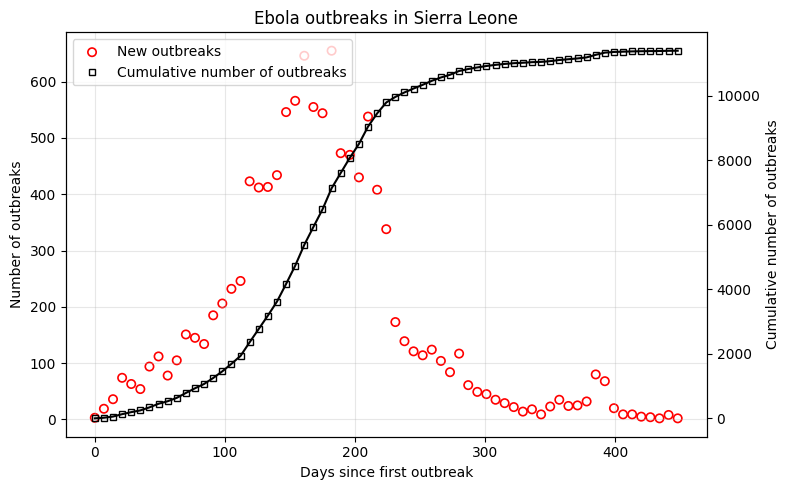

Sierra Leone: total cumulative = 11392, peak new = 655 at day ≈ 182


In [17]:
plot_country(DATA_DIR / "ebola_cases_guinea.dat",        "Guinea",        7)
plot_country(DATA_DIR / "ebola_cases_liberia.dat",       "Liberia",       7)
plot_country(DATA_DIR / "ebola_cases_sierra_leone.dat",  "Sierra Leone",  7)

### Task 1

In this task we fit a straight line to the Ebola data for Guinea, Liberia, and Sierra Leone as a simple baseline. For each country we use the time since first outbreak $t$ (days) as the feature and fit separate models to new cases and cumulative cases using scikit-learn `LinearRegression`. The model is

$
\hat{y}(t)=a\,t+b
$

where $a$ is the slope and $b$ the intercept. We evaluate each fit with the coefficient of determination $R^2$ and the root-mean-square error (RMSE):


$
R^2 = 1 - \frac{\sum_i\big(y_i-\hat{y}_i\big)^2}{\sum_i\big(y_i-\bar y\big)^2},
\qquad
\mathrm{RMSE}=\sqrt{\frac{1}{n}\sum_i\big(y_i-\hat{y}_i\big)^2}
$

Because epidemic curves are non-linear (waves for new; sigmoids for cumulative), a single line is only a rough approximation.

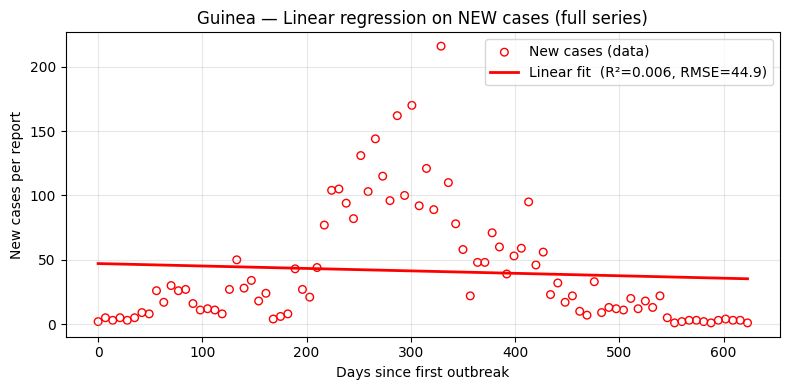

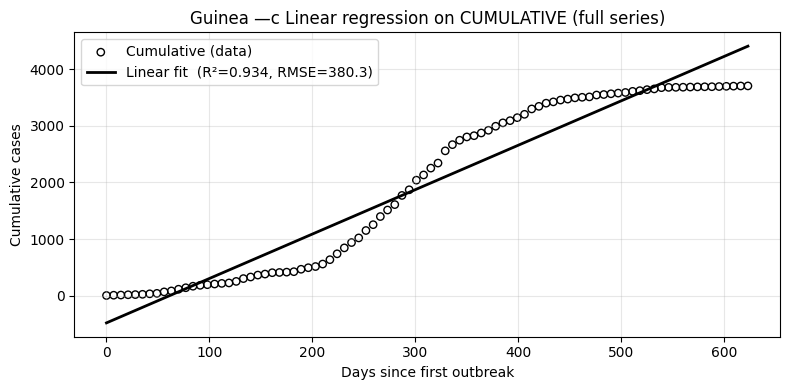

Guinea (NEW):   y ≈ -0.019·t + 47.1
Guinea (CUMUL): y ≈ 7.852·t + -482.2



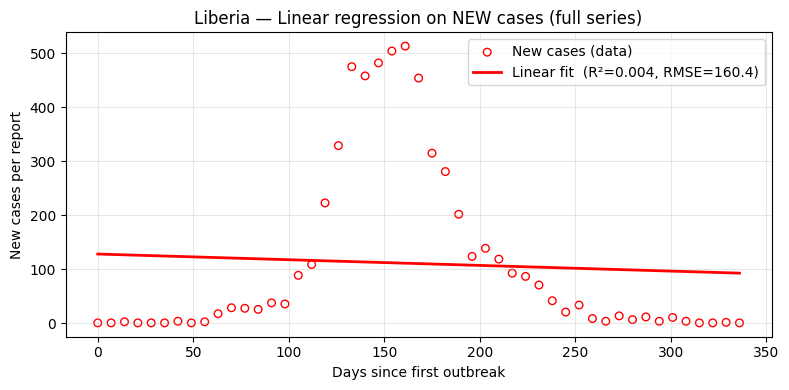

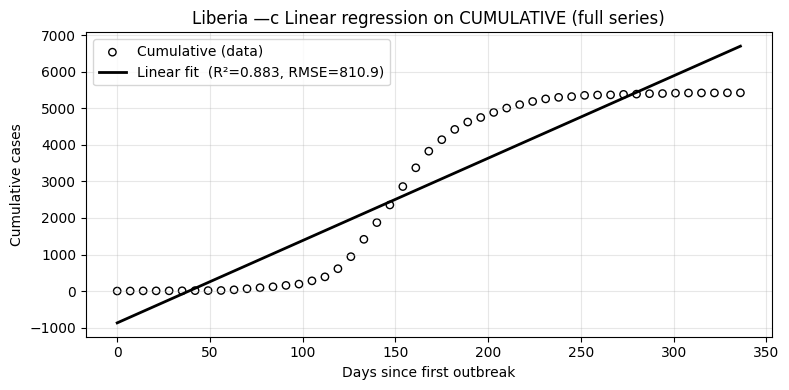

Liberia (NEW):   y ≈ -0.105·t + 128.4
Liberia (CUMUL): y ≈ 22.533·t + -870.5



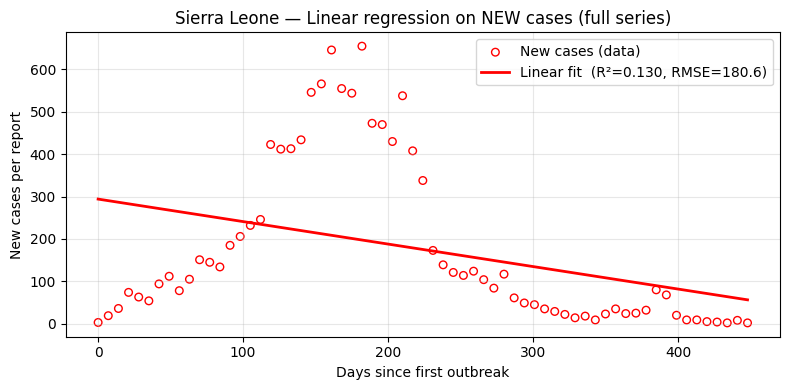

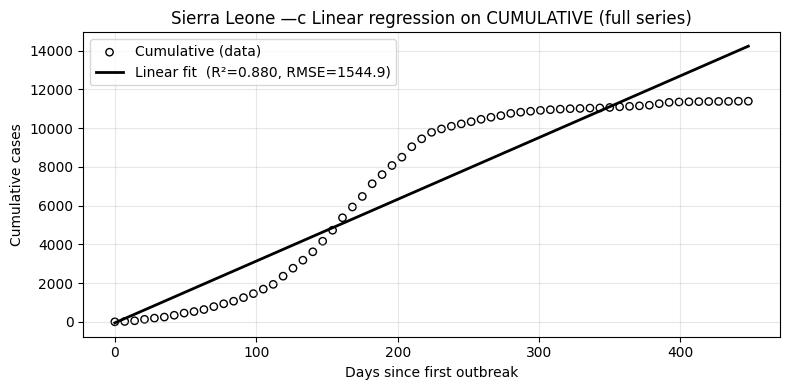

Sierra Leone (NEW):   y ≈ -0.531·t + 294.1
Sierra Leone (CUMUL): y ≈ 31.886·t + -51.3



In [18]:
# --- RUN: choose window_days=None for full series, or e.g. 150 for early phase
for country, path in COUNTRIES.items():
    plot_with_linear_fit(path, country, step_days=7, window_days=None)

In this task we fit a straight line to each country’s Ebola new and cumulative cases using
$ \hat{y}(t)=a\,t+b $, and evaluated with
$ R^2 $
and
$ \mathrm{RMSE} $.

- New cases: A single line fits poorly in all three countries.  
  Guinea: 
  $R^2=0.006$, 
  $\mathrm{RMSE}\approx 44.9$, 
  slope $-0.019$ cases/day.  
  Liberia: 
  $R^2=0.004$, 
  $\mathrm{RMSE}\approx 160.4$, 
  slope $-0.105$ cases/day.  
  Sierra Leone: $R^2=0.130$, $\mathrm{RMSE}\approx 180.6$, slope $-0.531$ cases/day.  
  The negative slopes arise because the series spans both rise and decline, so a single line cannot capture the wave-shaped incidence.

- Cumulative cases: A line is a better approximation of the central portion of the sigmoid-like curve.  
  Guinea: $R^2=0.934$, $\mathrm{RMSE}\approx 380.3$, slope $7.852$ cases/day.  
  Liberia: $R^2=0.883$, $\mathrm{RMSE}\approx 810.9$, slope $22.533$ cases/day.  
  Sierra Leone: $R^2=0.880$, $\mathrm{RMSE}\approx 1544.9$, slope $31.886$ cases/day.  
  Large RMSE is expected because cumulative counts are in the thousands and errors are squared.

Linear regression is a reasonable baseline for cumulative totals and a poor model for incident cases. It offers quick, interpretable trends (slope/intercept), but more flexible models (early-window or piecewise fits, polynomial/regularized regression, neural sequence models) are better for forecasting and for the wave-shaped new-cases series.

### Task 2
Here we want to train a better fitting function than a single straight line for the Ebola case data from the three countries.  
We define the linear regression in terms of a linear relationship between the parameters, not necessarily a linear relationship in the input variable. A general linear model can be written as

$
\hat{y} = \beta_0 + \beta_1 f_1(x) + \beta_2 f_2(x) + \dots + \beta_n f_n(x),
$

where the functions $f_i(x)$ may be nonlinear in $x$.  
A polynomial model is therefore still a linear regression model, because it is linear in the coefficients $\beta_i$:

$
\hat{y} = \beta_0 + \beta_1 t + \beta_2 t^2 + \cdots + \beta_d t^d .
$

To fit such a model, we construct a design matrix

$
X = 
\begin{bmatrix}
1 & t_1 & t_1^2 & \cdots & t_1^d \\
1 & t_2 & t_2^2 & \cdots & t_2^d \\
\vdots & \vdots & \vdots &        & \vdots \\
1 & t_n & t_n^2 & \cdots & t_n^d
\end{bmatrix},
$

and solve for the parameter vector $b$ using the normal equation

$
b = (X^\top X)^{-1} X^\top y.
$

Choosing $d = 1$ reproduces an ordinary straight-line fit.  
Choosing $d > 1$ allows the regression to follow the nonlinear shape of the outbreak more closely, giving a “better fitting function" while remaining completely inside the linear-regression framework described in the curriculum.

In this task we apply polynomial linear regression separately to the new cases and the cumulative cases, compare the fitted curve with the observed data, and evaluate the fit using the root-mean-square error (RMSE) and the coefficient of determination $R^2$.

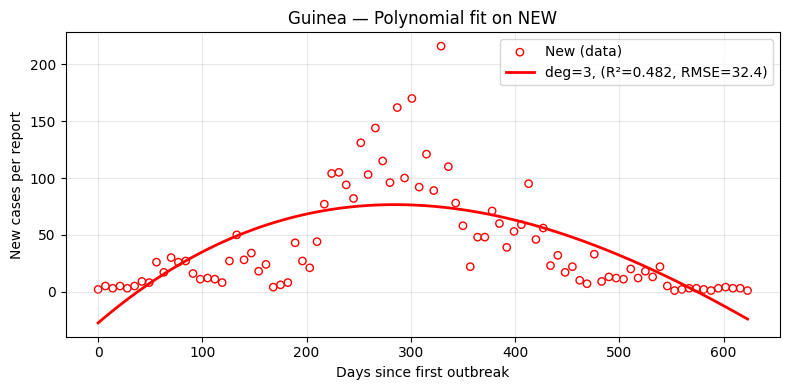

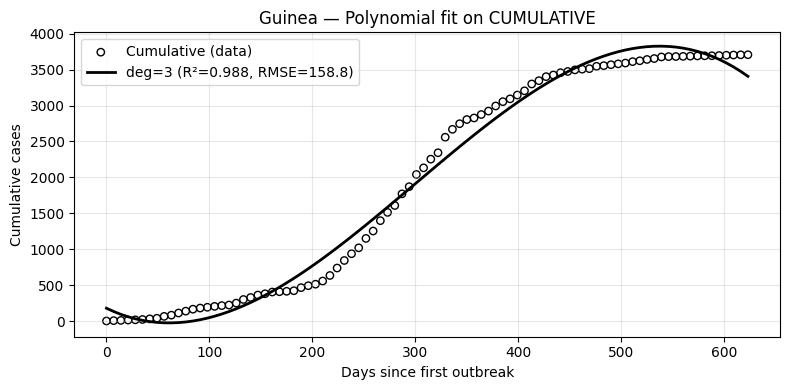

Guinea NEW   -> degree=3,  R²=0.482, RMSE=32.4
Guinea CUMUL -> degree=3,  R²=0.988, RMSE=158.8


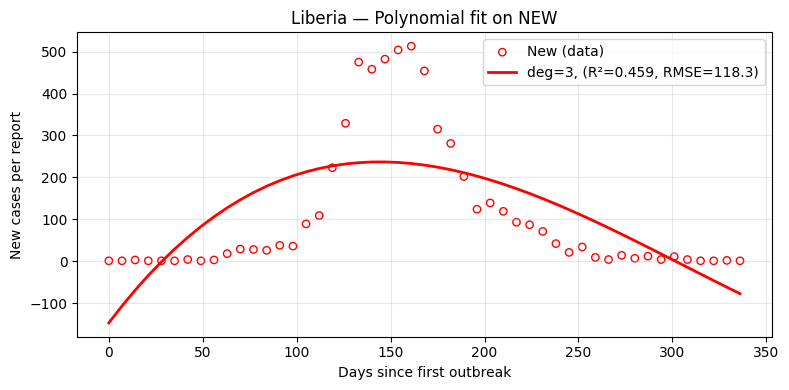

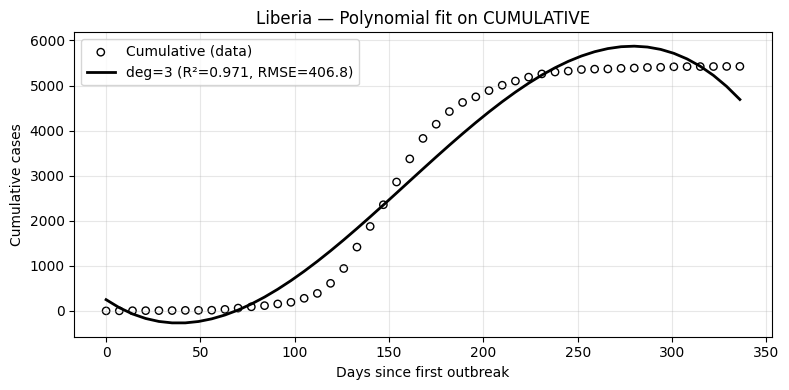

Liberia NEW   -> degree=3,  R²=0.459, RMSE=118.3
Liberia CUMUL -> degree=3,  R²=0.971, RMSE=406.8


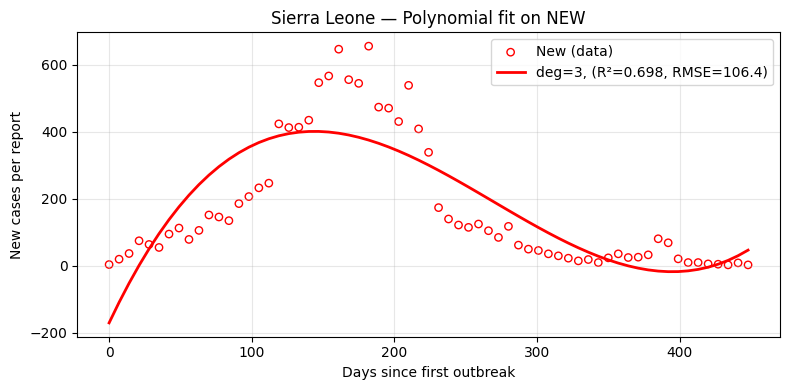

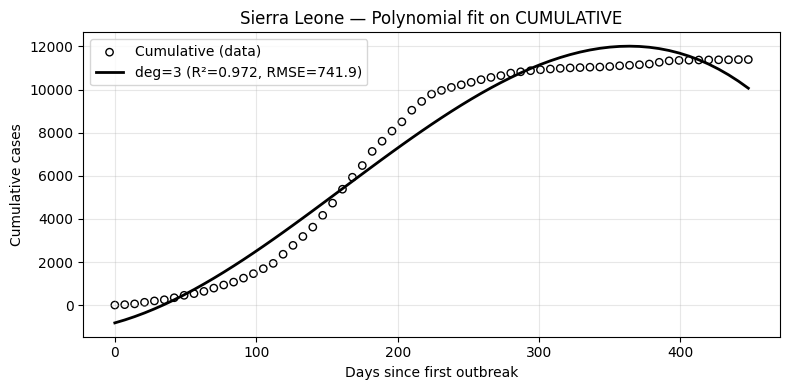

Sierra Leone NEW   -> degree=3,  R²=0.698, RMSE=106.4
Sierra Leone CUMUL -> degree=3,  R²=0.972, RMSE=741.9


In [19]:
for country, path in COUNTRIES.items():
    run_country_poly_basic(path, country, step_days=7, degree_new=3, degree_cum=3)

Using a polynomial linear regression model with degree $d = 3$ provided a noticeably better fit than a simple straight line for all three countries. The polynomial model was better suited to follow the nonlinear structure of the epidemic curves, especially for the cumulative case counts, where the regression showed the S-shaped growth pattern.

For the new cases time series, the fitted curves showed moderate explanatory power, with $R^{2}$ values between $0.46$ and $0.70$. This reflects the higher variability and noise in the day-to-day reporting of new infections. The RMSE values show the model captures only the broad trend (noise is high). In contrast, the cumulative cases behaved much more smoothly, producing very high $R^{2}$ values between $0.97$ and $0.99$, indicating that a cubic polynomial can approximate the overall progression of the outbreak reasonably well. And RMSE values are small here relative to the total case counts, reinforcing that the cubic model fits well.

Overall, the results show that polynomial basis functions allow us to construct a better fitting function than a single line.

### Task 3

In this task we train a small neural network to learn and predict the progression of the Ebola outbreaks. The objective is to approximate the nonlinear relationship between time $t$ and the number of reported cases. Unlike linear or polynomial regression, the neural network does not assume any specific functional form; instead, it attempts to learn the mapping $t \mapsto y(t)$ directly from the data through stacked linear transformations and nonlinear activations, consistent with the curriculum’s description of feed-forward networks.

For each country (Guinea and Liberia), we train two separate models: one for the new-cases series and one for the cumulative cases. Because this is a temporal dataset, the training and test sets must respect the ordering in time. We therefore use the first $70\%$ of the outbreak as training data and reserve the final $30\%$ for testing. This prevents information leakage and ensures that the network is always asked to predict future observations from past data.

Before training, both the input variable (time) and the output variable (new or cumulative cases) are scaled to the interval $[0,1]$. Neural networks train more reliably when inputs lie within a standardized numerical range.

The architecture is made up of two hidden layers with $64$ and $32$ ReLU units, followed by a single linear output neuron. This design provides enough capacity to learn broad nonlinear patterns such as the rise and fall of new cases or the S-shaped cumulative growth while remaining simple. The network is trained for 200 epochs using mean-squared error, and model performance on the test region is evaluated using $R^2$ and RMSE.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


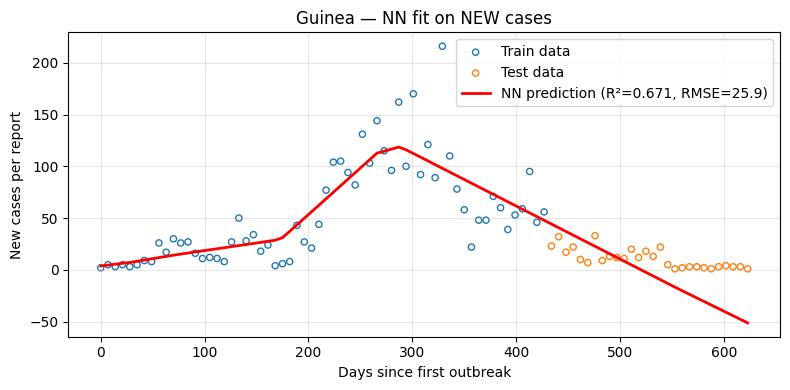

Guinea NEW -> R² = 0.6708629700424322 RMSE = 25.858449096949506
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


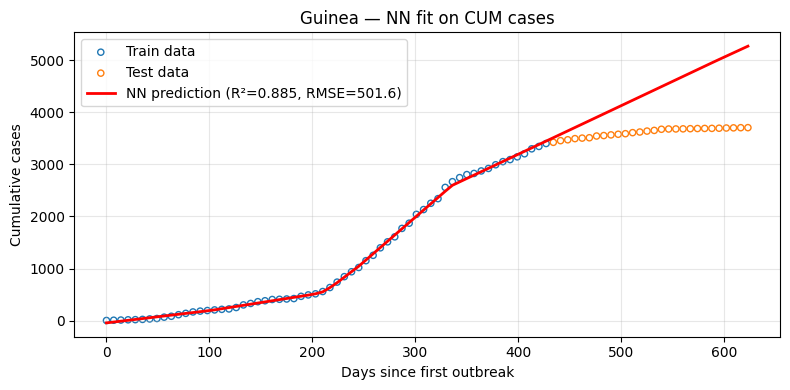

Guinea CUMUL -> R² = 0.8847803904083147 RMSE = 501.5891611124462
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


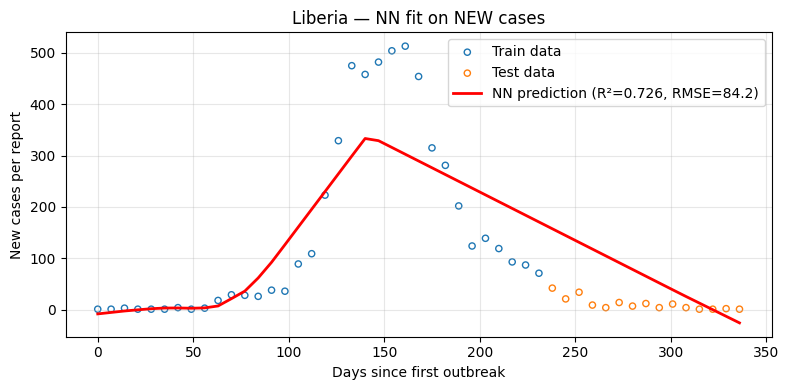

Liberia NEW -> R² = 0.7257300736741148 RMSE = 84.20240801715346
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


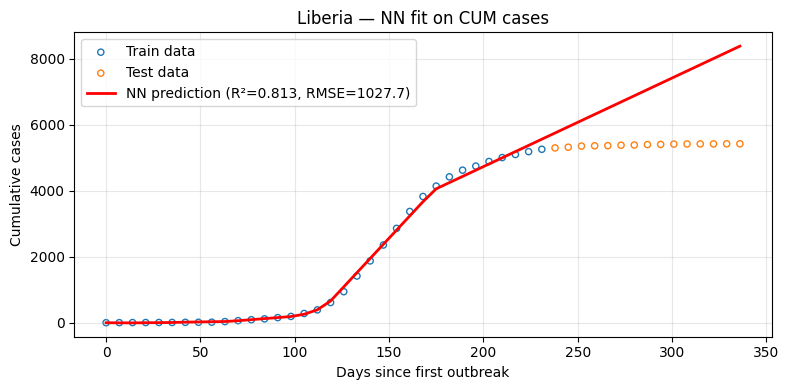

Liberia CUMUL -> R² = 0.8125202028986124 RMSE = 1027.6982086397413


In [3]:
set_global_seed(2)  # for reproducibility

res_guinea_new = train_nn_ebola(
    path=COUNTRIES["Guinea"],
    country="Guinea",
    target="new",  
    train_frac=0.7,        # 70% earliest data = train, last 30% = test
    hidden_units=(64, 32), # two hidden layers with 64 and 32 units
    lr=1e-3,                # learning rate 
    epochs=200,             # max number of epochs
    batch_size=16,         # batch size
    verbose=0,             # no training output
)

plot_nn_result(res_guinea_new)
print("Guinea NEW -> R² =", res_guinea_new["r2"], "RMSE =", res_guinea_new["rmse"])

res_guinea_cum = train_nn_ebola(
    path=COUNTRIES["Guinea"],
    country="Guinea",
    target="cum",
    train_frac=0.7,
    hidden_units=(64, 32),
    lr=1e-3,
    epochs=200,
    batch_size=16,
    verbose=0,
)
plot_nn_result(res_guinea_cum)
print("Guinea CUMUL -> R² =", res_guinea_cum["r2"], "RMSE =", res_guinea_cum["rmse"])

res_liberia_new = train_nn_ebola(
    path=COUNTRIES["Liberia"],
    country="Liberia",
    target="new",
    train_frac=0.7,
    hidden_units=(64, 32),
    lr=1e-3,
    epochs=200,
    batch_size=16,
    verbose=0,
)
plot_nn_result(res_liberia_new)
print("Liberia NEW -> R² =", res_liberia_new["r2"], "RMSE =", res_liberia_new["rmse"])


res_liberia_cum = train_nn_ebola(
    path=COUNTRIES["Liberia"],
    country="Liberia",
    target="cum",
    train_frac=0.7,
    hidden_units=(64, 32),
    lr=1e-3,
    epochs=200,
    batch_size=16,
    verbose=0,
)

plot_nn_result(res_liberia_cum)
print("Liberia CUMUL -> R² =", res_liberia_cum["r2"], "RMSE =", res_liberia_cum["rmse"])

For Guinea, the neural network produced a reasonable fit for the new-case series, achieving $R^2 \approx 0.671$ and RMSE $\approx 25.9$. The model captured the overall rise, peak, and decline of the epidemic, although it still smoothed out much of the high-frequency noise. For cumulative cases, the NN reached $R^2 \approx 0.885$ with RMSE $\approx 501.6$. The prediction followed the main epidemic curve but over-estimated the later, flatter part of the trajectory.

For Liberia, the pattern was similar. The NN performed well on new cases, with $R^2 \approx 0.726$ and RMSE $\approx 84.2$, but falls a little short of successfully reproducing the rapid growth and sharp peak around day 150. For cumulative cases, the performance decreased compared to Guinea, giving $R^2 \approx 0.813$ and RMSE $\approx 1027.7$. The model tracked the early and middle stages of the outbreak but extrapolated too aggressively in the test region, leading to an upward drift after the real curve begins to flatten.

Overall, the results show that neural networks can learn nonlinear epidemic dynamics from data, especially when fitting smooth cumulative curves or prominent large-scale features such as the main outbreak peak. However, their performance is sensitive to noise levels, training length, and the behavior of the test region. In particular, noisy new-case data require more model capacity to avoid underfitting, while cumulative curves can still over-shoot if the NN extrapolates beyond the observed training pattern.

Because the dataset is small and the model is stochastic, moderate variability between training runs is expected. Neural networks do not automatically outperform simpler models on short time series, and their behavior depends strongly on architectural choices, scaling, and the temporal structure of the data.

### Task 4

In this task we applied an LSTM (Long Short-Term Memory) network to the Ebola time series. LSTMs are a type of recurrent neural network designed for sequential data, because they keep an internal state that helps them learn dependencies over time. This makes them suitable for predicting how an epidemic evolves from its recent history.

To prepare the data, each time series is transformed into small input–target pairs of the form

$$
[y(t-1),\, y(t-2),\, \ldots,\, y(t-\text{seq\_len})] \;\mapsto\; y(t),
$$

so the model receives a short window of past case counts and tries to predict the next value. As in the previous tasks, the first 70% of the timeline is used for training and the remaining 30% for testing, ensuring that the model always predicts forward in time. The values are scaled to the interval $[0,1]$ before training, since LSTMs are sensitive to input magnitude.


Epoch 1/400
4/4 - 1s - 173ms/step - loss: 0.1292
Epoch 2/400
4/4 - 0s - 7ms/step - loss: 0.1167
Epoch 3/400
4/4 - 0s - 7ms/step - loss: 0.1054
Epoch 4/400
4/4 - 0s - 8ms/step - loss: 0.0950
Epoch 5/400
4/4 - 0s - 7ms/step - loss: 0.0857
Epoch 6/400
4/4 - 0s - 7ms/step - loss: 0.0772
Epoch 7/400
4/4 - 0s - 7ms/step - loss: 0.0697
Epoch 8/400
4/4 - 0s - 7ms/step - loss: 0.0630
Epoch 9/400
4/4 - 0s - 6ms/step - loss: 0.0571
Epoch 10/400
4/4 - 0s - 8ms/step - loss: 0.0520
Epoch 11/400
4/4 - 0s - 7ms/step - loss: 0.0476
Epoch 12/400
4/4 - 0s - 7ms/step - loss: 0.0440
Epoch 13/400
4/4 - 0s - 7ms/step - loss: 0.0411
Epoch 14/400
4/4 - 0s - 7ms/step - loss: 0.0388
Epoch 15/400
4/4 - 0s - 7ms/step - loss: 0.0371
Epoch 16/400
4/4 - 0s - 7ms/step - loss: 0.0358
Epoch 17/400
4/4 - 0s - 6ms/step - loss: 0.0348
Epoch 18/400
4/4 - 0s - 6ms/step - loss: 0.0341
Epoch 19/400
4/4 - 0s - 8ms/step - loss: 0.0335
Epoch 20/400
4/4 - 0s - 6ms/step - loss: 0.0331
Epoch 21/400
4/4 - 0s - 6ms/step - loss: 0.0327

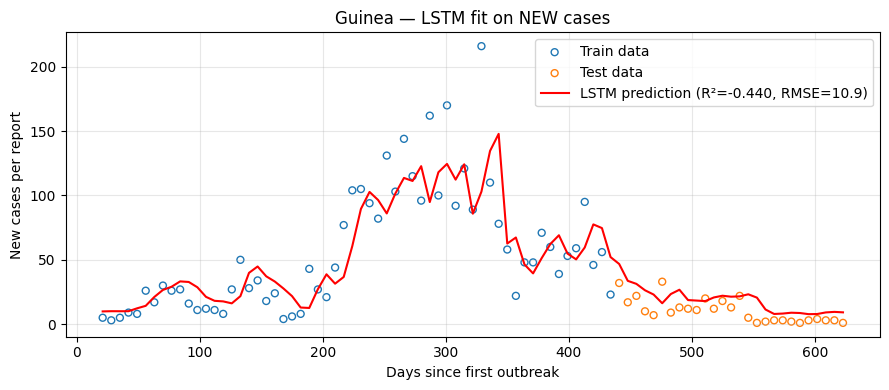

Guinea NEW -> R² = -0.43998485777343155 RMSE = 10.88765244206371


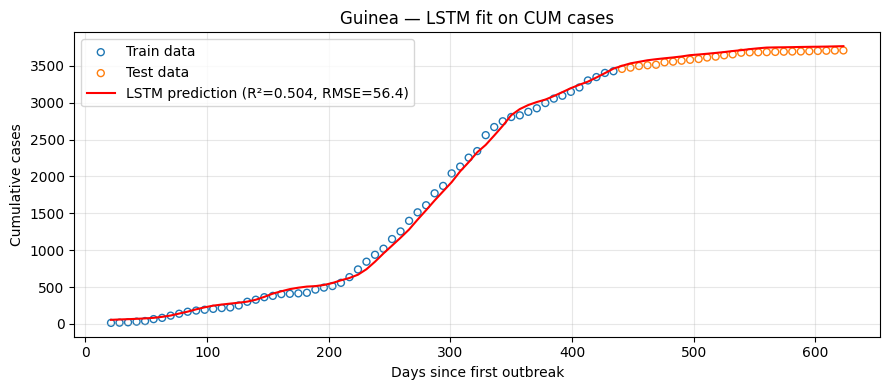

Guinea CUMUL -> R² = 0.5037228751698368 RMSE = 56.35363753734955


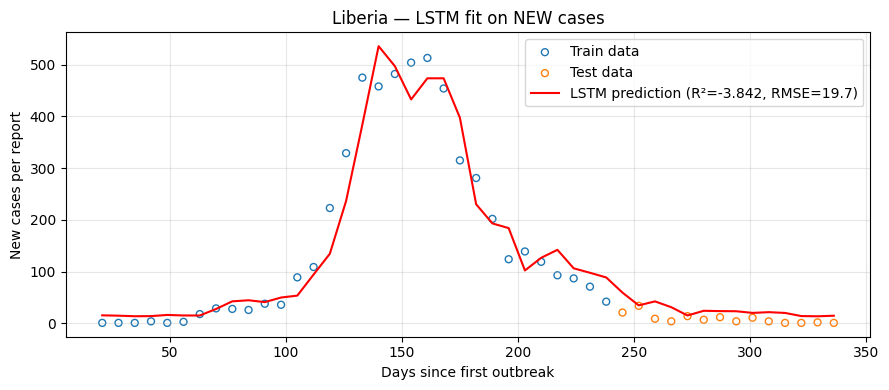

Liberia NEW -> R² = -3.8417472012343277 RMSE = 19.74173110209741


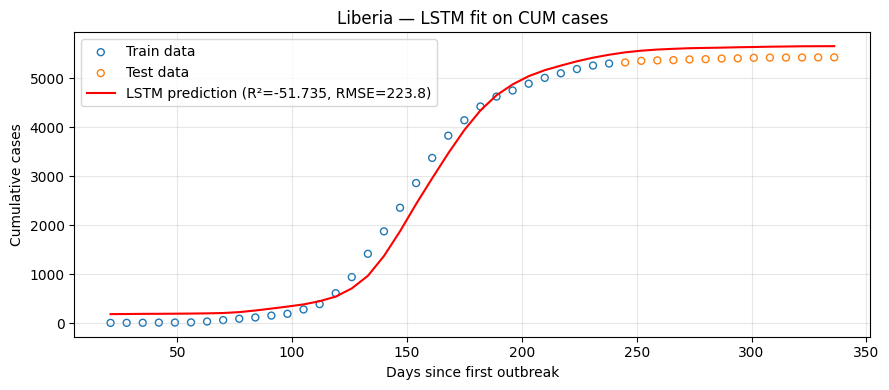

Liberia CUMUL -> R² = -51.7350834783783 RMSE = 223.81273646476672


In [2]:
set_global_seed(1) 
# Guinea – NEW cases
res_gn_new = train_lstm_ebola(
    path=COUNTRIES["Guinea"],
    country="Guinea",
    target="new",
    seq_len=3,
    train_frac=0.7,
    units=32,
    lr=1e-3,
    epochs=400,
    batch_size=16,
    verbose=2,
)
plot_lstm_result(res_gn_new)
print("Guinea NEW -> R² =", res_gn_new["r2"], "RMSE =", res_gn_new["rmse"])

# Guinea – CUMULATIVE cases
res_gn_cum = train_lstm_ebola(
    path=COUNTRIES["Guinea"],
    country="Guinea",
    target="cum",
    seq_len=3,
    train_frac=0.7,
    units=32,
    lr=1e-3,
    epochs=400,
    batch_size=16,
    verbose=0,
)
plot_lstm_result(res_gn_cum)
print("Guinea CUMUL -> R² =", res_gn_cum["r2"], "RMSE =", res_gn_cum["rmse"])

# Liberia – NEW cases
res_lb_new = train_lstm_ebola(
    path=COUNTRIES["Liberia"],
    country="Liberia",
    target="new",
    seq_len=3,
    train_frac=0.7,
    units=32,
    lr=1e-3,
    epochs=400,
    batch_size=16,
    verbose=0,
)
plot_lstm_result(res_lb_new)
print("Liberia NEW -> R² =", res_lb_new["r2"], "RMSE =", res_lb_new["rmse"])

# Liberia – CUMULATIVE cases
res_lb_cum = train_lstm_ebola(
    path=COUNTRIES["Liberia"],
    country="Liberia",
    target="cum",
    seq_len=3,
    train_frac=0.7,
    units=32,
    lr=1e-3,
    epochs=400,
    batch_size=16,
    verbose=0,
)
plot_lstm_result(res_lb_cum)
print("Liberia CUMUL -> R² =", res_lb_cum["r2"], "RMSE =", res_lb_cum["rmse"])

### Task 5 
In this task I tested whether an LSTM could predict the Ebola time series without using any epidemiological model. The results show that this is difficult. For the cumulative data the LSTM can follow the general curve, but for the new-cases series the predictions are unstable, and the $R^2$ values are often negative. This means the model does not generalize well once it reaches parts of the outbreak it has not seen during training.

**Can we ignore modeling and let machine learning make predictions?**  
Based on these results, the answer is no. With short and noisy datasets like these, the LSTM does not learn enough structure to make reliable forecasts. Machine learning alone is not a replacement for epidemic modeling.

**What is a good prediction for these cases?**  
For this type of data, good predictions should capture the overall trend rather than exact day-to-day fluctuations. The cumulative curves were the most stable, so predicting the long-term shape (the rise and eventual plateau) works better than predicting new daily cases.

**What are your conclusions?**  
The main conclusion is that pure machine learning struggles with limited epidemic data. Traditional models that include assumptions about how diseases spread are still necessary for meaningful forecasting. The LSTM can help smooth the signal, but it is not reliable enough on its own to predict the epidemic evolution.

# References
[1] T. A. Rector & K. Levay, *Image-Processing Techniques for the Creation of Astronomical Images*, 2007.  
Available at: https://w.astro.berkeley.edu/~kalas/disksite/library/rector07a.pdf

[2] OpenCV Documentation – Image Thresholding.  
    https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

[3] Astropy Photutils – Segmentation and Threshold-based Source Detection.  
    https://photutils.readthedocs.io/en/stable/segmentation.html

[4] Scikit-Image – Global Thresholding (Otsu’s Method).  
    https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_thresholding.html

[5] Kelvin, L. S., et al. *Sky subtraction in an era of low surface brightness astronomy*,  
Monthly Notices of the Royal Astronomical Society, 520(2), 2484–2503 (2023).  
Available at: https://academic.oup.com/mnras/article/520/2/2484/6991433

[6] Sloan Digital Sky Survey (SDSS) – Imaging basics and filter system (u, g, r, i, z).  
    Available at: https://www.sdss4.org/dr17/imaging/imaging_basics/

[7] Photometry (astronomy) – overview of measuring flux/brightness with calibrated filters.  
    https://en.wikipedia.org/wiki/Photometry_(astronomy)

[8] HSL and HSV – definitions and properties of hue, saturation, value/lightness color spaces, and their limitations.  
    https://en.wikipedia.org/wiki/HSL_and_HSV

[9] Color Presentation of Astronomical Images – true/false color and mapping intensity data to RGB.  
    https://www.allthesky.com/articles/imagecolor.html

[10] R. Lupton et al., *Preparing Red-Green-Blue Images from CCD Data*, PASP 116, 133 (2004).  
     Abstract: https://ui.adsabs.harvard.edu/abs/2004PASP..116..133L/abstract

[11] Jason Brownlee, Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras, 2022
     https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


# Requirements

### AI usage
- AI has been used to find relevant references, refine points and structure discussion parts.
- Used autocomplete for some comments and docstrings due to time constraints.

### Individual contributions
- Espen Larsen focused on Topic 1.
- Amund Romseland Brevik focused on Topic 2.
- A lot of cross collaboration and refinements to each others code and text have also been done.

### Self-reflection Espen Larsen
- This project gave me a clearer understanding of how strongly unsupervised learning depends on the choice of features and encodings. I saw firsthand that different representations of the same image (greyscale, HSV, RGB) produce very different clusters, and that these patterns do not automatically correspond to real astrophysical structures. 
- The work also highlighted the limitations of unsupervised methods, which can easily group pixels based on rendering artifacts, brightness scaling, or color-mapping choices rather than physical properties.
- Building reusable functions and a clean workflow helped me experiment more effectively and understand each step in the pipeline. Overall, the project reinforced that in scientific machine learning, results must be interpreted carefully, and domain knowledge is essential to avoid over-interpreting what the clusters seem to show.

### Self-reflection Amund Brevik
- Working through these tasks helped me get a more practical understanding of supervised learning and how different models behave on real epidemic data. The early tasks (linear regression and polynomial regression) were straightforward, and I felt confident experimenting with different model degrees and interpreting the results. Training a basic neural network in Task 3 also made sense once I understood how the training/test split must respect the time ordering.
- The LSTM part was more challenging. I had never built an LSTM model from scratch before, and I had to spend extra time learning how sequences are constructed and why time-series models behave differently from standard feed-forward networks. Because I was running low on time, I was not able to explore the topic as thoroughly as I would have liked. This likely contributed to the unstable and sometimes negative $R^2$ values I observed, especially for the cumulative case predictions. Still, the exercise helped me see why LSTMs require larger datasets and careful tuning to perform well.